# Stock Market Analysis – Capstone (Resumen para Estudio)

**Formato:** Notebook de estudio con teoría + ejemplos + ejercicios resueltos  
**Fecha de preparación:** 2025-09-21 (UTC)

Este cuaderno resume y estructura el proyecto *Stock Market Analysis Capstone* del curso (transcriptor provisto), con:
- Explicaciones en **Markdown** (economía/finanzas en Python).
- **Ejemplos** listos para ejecutar con `numpy`, `pandas` y `matplotlib`.
- **Ejercicios resueltos** paso a paso.
- Sección de **Time Series** con `statsmodels` (opcional).

> **Nota sobre datos**: Si `pandas-datareader`/internet no están disponibles, usa los CSV locales (`TSLA.csv`, `F.csv`, `GM.csv`) o el generador de datos sintéticos incluido.


## 0. Setup e Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline  # Descomenta en Jupyter clásico
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
print("Versiones -> pandas:", pd.__version__)

Versiones -> pandas: 2.3.2


## 1. Cargar Datos (TSLA, F, GM) – 2012-01-01 a 2017-01-01

Intentamos en este orden:
1) **CSV locales** (`TSLA.csv`, `F.csv`, `GM.csv`) con columnas: `Date, Open, High, Low, Close, Volume`.
2) **Generador sintético** (si no hay CSV o internet).

> Mantendremos `Date` como índice `DatetimeIndex`.


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

def load_from_csv(ticker, fname):
    p = Path(fname)
    if not p.exists():
        return None
    df = pd.read_csv(p, parse_dates=["Date"])
    df = df.set_index("Date").sort_index()
    cols = {c: c.strip().title() for c in df.columns}
    df = df.rename(columns=cols)
    return df[["Open","High","Low","Close","Volume"]]

def make_synthetic(ticker, start="2012-01-01", end="2017-01-01", seed=0):
    rng = np.random.default_rng(abs(hash(ticker)) % (2**32) + seed)
    dates = pd.date_range(start, end, freq="B")
    n = len(dates)
    drift = {"TSLA": 0.0008, "GM": 0.0002, "F": 0.00015}.get(ticker, 0.0003)
    vol = {"TSLA": 0.03, "GM": 0.015, "F": 0.012}.get(ticker, 0.02)
    log_returns = rng.normal(drift, vol, size=n)
    price = 20 * np.exp(np.cumsum(log_returns))
    open_ = price
    high = open_ * (1 + rng.normal(0.001, 0.01, size=n).clip(-0.02, 0.05))
    low  = open_ * (1 - rng.normal(0.001, 0.01, size=n).clip(-0.05, 0.02))
    close = open_ * (1 + rng.normal(0, 0.01, size=n))
    volume = rng.integers(1e6, 5e6, size=n) * (1 + (ticker=="TSLA")*rng.choice([0,5], size=n, p=[0.98,0.02]))
    df = pd.DataFrame({"Open":open_, "High":high, "Low":low, "Close":close, "Volume":volume}, index=dates)
    df.index.name = "Date"
    return df

def get_ticker_df(ticker, csv_name):
    df = load_from_csv(ticker, csv_name)
    if df is None or df.empty:
        print(f"[{ticker}] CSV no encontrado. Generando datos sintéticos…")
        df = make_synthetic(ticker)
    df = df.loc["2012-01-01":"2017-01-01"]
    return df

TSLA = get_ticker_df("TSLA", "TSLA.csv")
F    = get_ticker_df("F",    "F.csv")
GM   = get_ticker_df("GM",   "GM.csv")

TSLA.head()

[TSLA] CSV no encontrado. Generando datos sintéticos…
[F] CSV no encontrado. Generando datos sintéticos…
[GM] CSV no encontrado. Generando datos sintéticos…


,Open,High,Low,Close,Volume
Date,,,,,
2012-01-02,19.1676,19.3374,19.1507,19.2988,3405508
2012-01-03,17.6843,17.5105,17.4082,17.7844,3540768
2012-01-04,18.1202,18.6571,18.4868,17.9615,6796158
2012-01-05,18.6802,18.7307,18.3066,18.8014,4320381
2012-01-06,18.7905,18.6674,19.0647,18.9860,4941603


**Observation:**  
The MA(50) and MA(200) smooth the noise and reveal the trend.  
A potential **Golden Cross** (MA50 > MA200) would indicate bullish momentum,  
while a **Death Cross** (MA50 < MA200) could signal bearish pressure.


## 2. Visualización Básica

### 2.1 Precio de Apertura (Open)
Comparación simple para intuir niveles (ojo: **no** refleja capitalización).


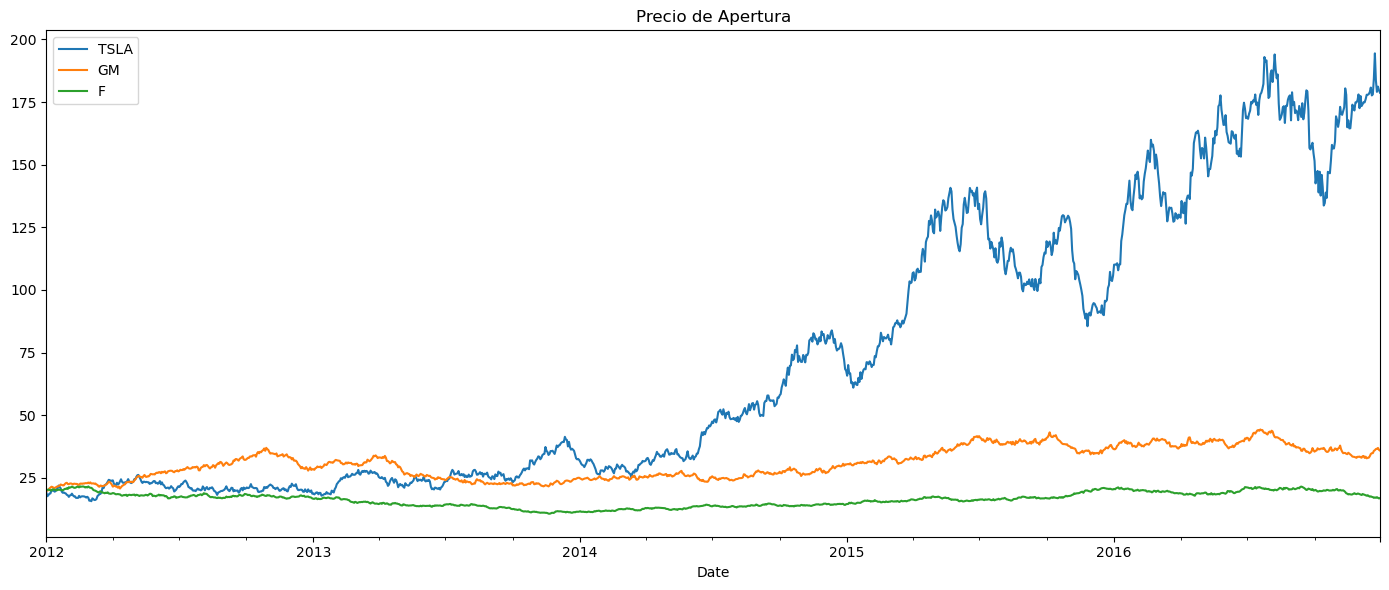

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
TSLA['Open'].plot(label='TSLA')
GM['Open'].plot(label='GM')
F['Open'].plot(label='F')
plt.title('Precio de Apertura')
plt.legend(); plt.tight_layout()

### 2.2 Volumen Diario
Útil para detectar **spikes** inusuales y posibles eventos.


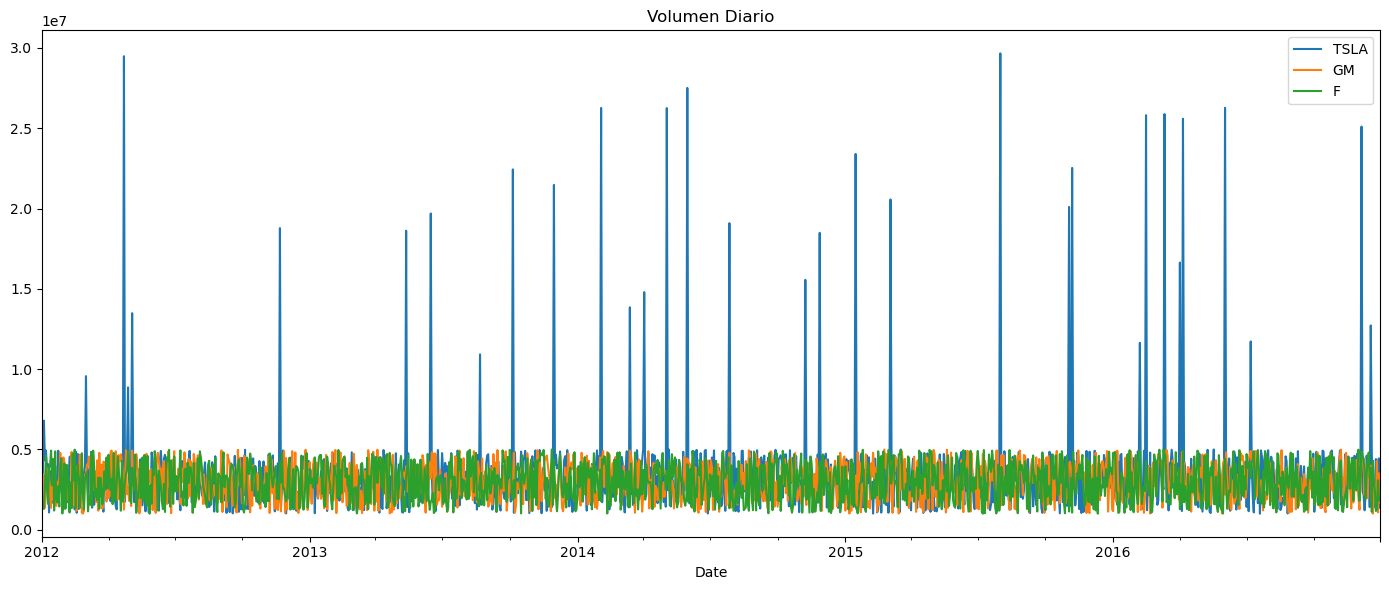

In [4]:
plt.figure(figsize=(14,6))
TSLA['Volume'].plot(label='TSLA')
GM['Volume'].plot(label='GM')
F['Volume'].plot(label='F')
plt.title('Volumen Diario')
plt.legend(); plt.tight_layout()

### 2.3 *Total Traded* (aprox. dinero intercambiado)
`TotalTraded = Open × Volume` (no es market cap; fin didáctico).


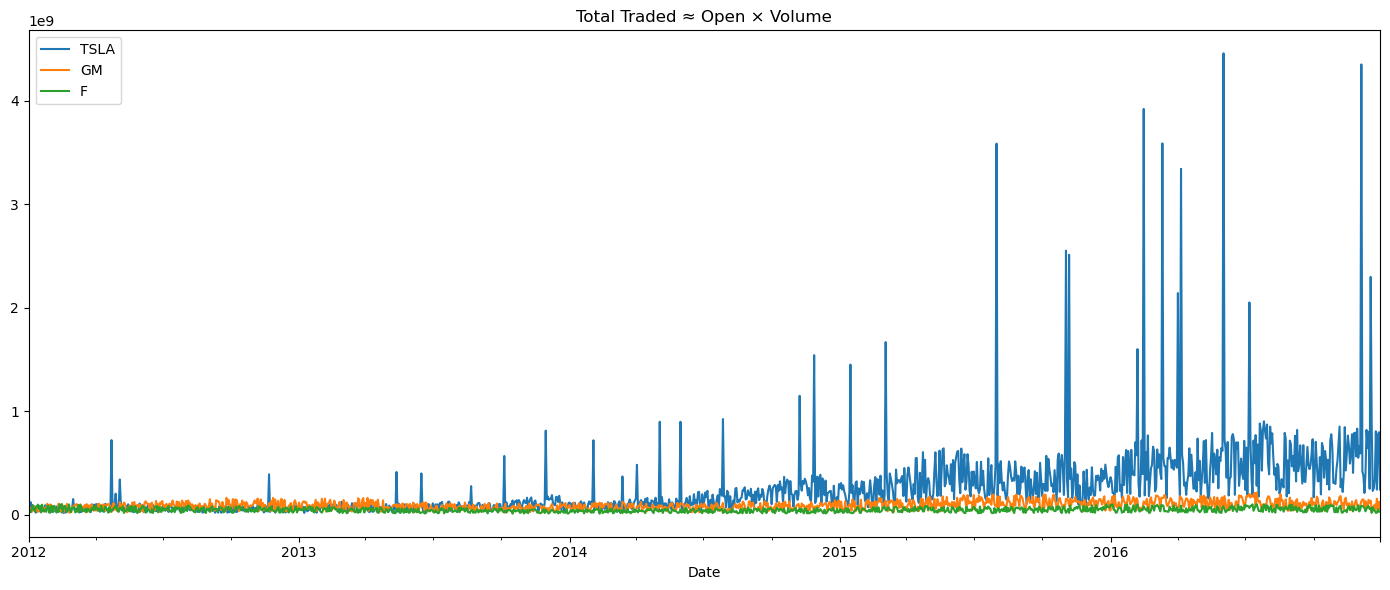

In [5]:
for df in (TSLA, GM, F):
    df['TotalTraded'] = df['Open'] * df['Volume']

plt.figure(figsize=(14,6))
TSLA['TotalTraded'].plot(label='TSLA')
GM['TotalTraded'].plot(label='GM')
F['TotalTraded'].plot(label='F')
plt.title('Total Traded ≈ Open × Volume')
plt.legend(); plt.tight_layout()

**Ejercicio resuelto (evento en pico de volumen – Ford):**
1) Encuentra la fecha de **máximo volumen** en `F`.
2) Muestra el precio de apertura ese día.


In [6]:
peak_date = F['Volume'].idxmax()
peak_vol  = F.loc[peak_date, 'Volume']
peak_open = F.loc[peak_date, 'Open']
print(f"Máximo volumen F en {peak_date.date()} -> {int(peak_vol):,} | Open = {peak_open:,.2f}")

Máximo volumen F en 2013-11-27 -> 4,997,412 | Open = 11.26


## 3. Medias Móviles y Scatter Matrix

### 3.1 Medias móviles (GM)
MA(50) y MA(200) para suavizar tendencia/estructura.


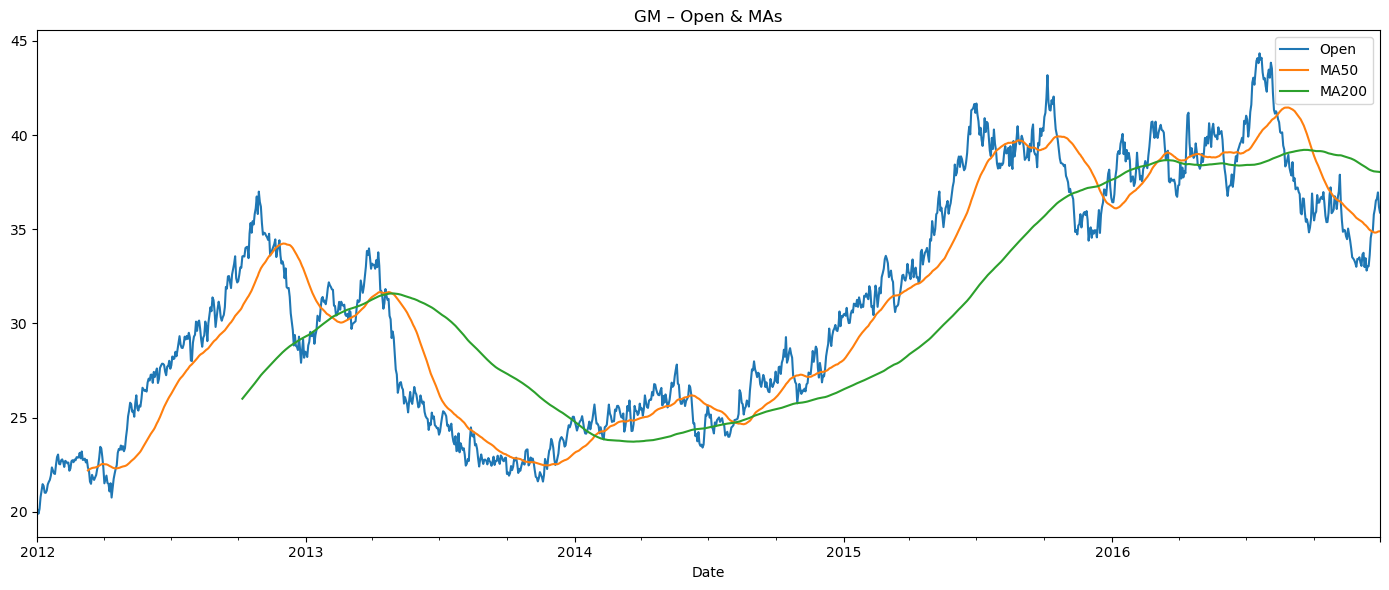

In [7]:
GM['MA50']  = GM['Open'].rolling(50).mean()
GM['MA200'] = GM['Open'].rolling(200).mean()
GM[['Open','MA50','MA200']].plot(figsize=(14,6), title='GM – Open & MAs')
plt.tight_layout()

### 3.2 Scatter Matrix (Open)
Visualiza relaciones entre precios de apertura.


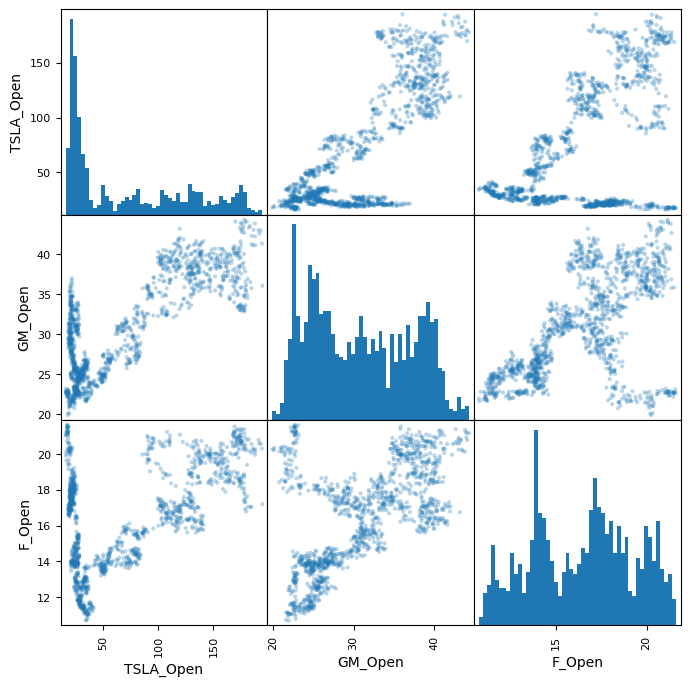

In [8]:
from pandas.plotting import scatter_matrix
open_df = pd.concat(
    [TSLA['Open'].rename('TSLA_Open'),
     GM['Open'].rename('GM_Open'),
     F['Open'].rename('F_Open')],
    axis=1
)
_ = scatter_matrix(open_df, figsize=(8,8), alpha=0.3, hist_kwds={'bins': 50})

## 4. Retornos Diarios y Volatilidad

**Definición (retorno diario):**
\( r_t = \frac{P_t}{P_{t-1}} - 1 \)

Usaremos `pct_change()` de pandas sobre `Close`.


In [9]:
for df in (TSLA, GM, F):
    df['Return'] = df['Close'].pct_change()
TSLA[['Close','Return']].head()

,Close,Return
Date,,
2012-01-02,19.2988,NaN
2012-01-03,17.7844,-0.0785
2012-01-04,17.9615,0.0100
2012-01-05,18.8014,0.0468
2012-01-06,18.9860,0.0098


### 4.1 Histogramas superpuestos (volatilidad relativa)
Distribuciones más anchas ⇒ **más volatilidad**.


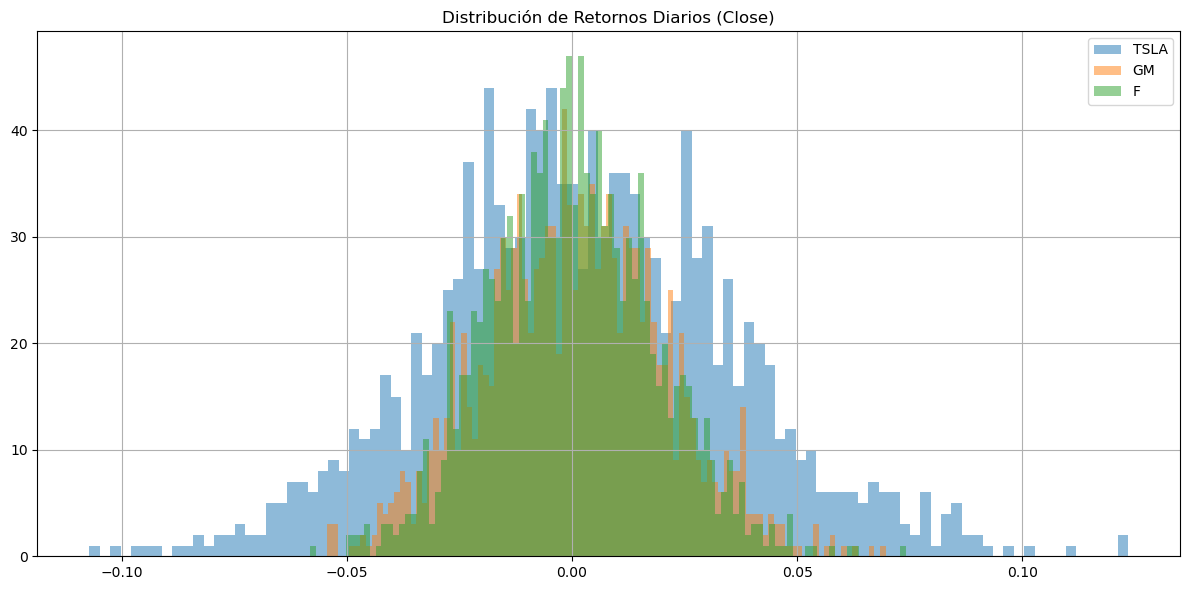

In [10]:
plt.figure(figsize=(12,6))
for name, df in [('TSLA', TSLA), ('GM', GM), ('F', F)]:
    df['Return'].hist(bins=100, alpha=0.5, label=name)
plt.title('Distribución de Retornos Diarios (Close)')
plt.legend(); plt.tight_layout()

### 4.2 KDE (curvas de densidad) y Boxplots
Otra forma de comparar estabilidad.


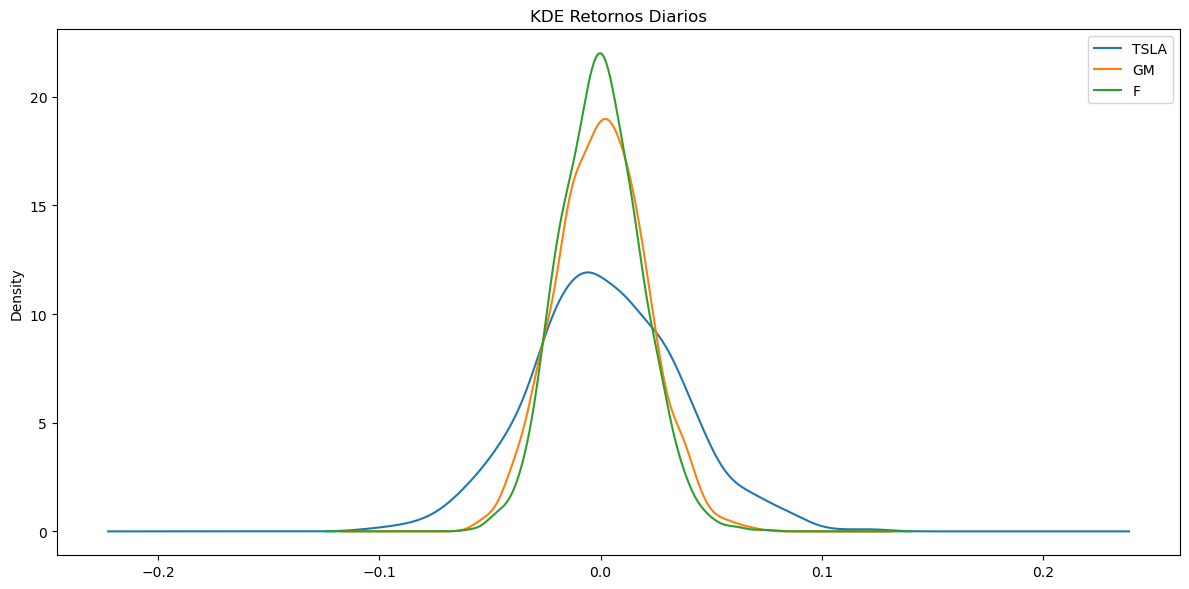

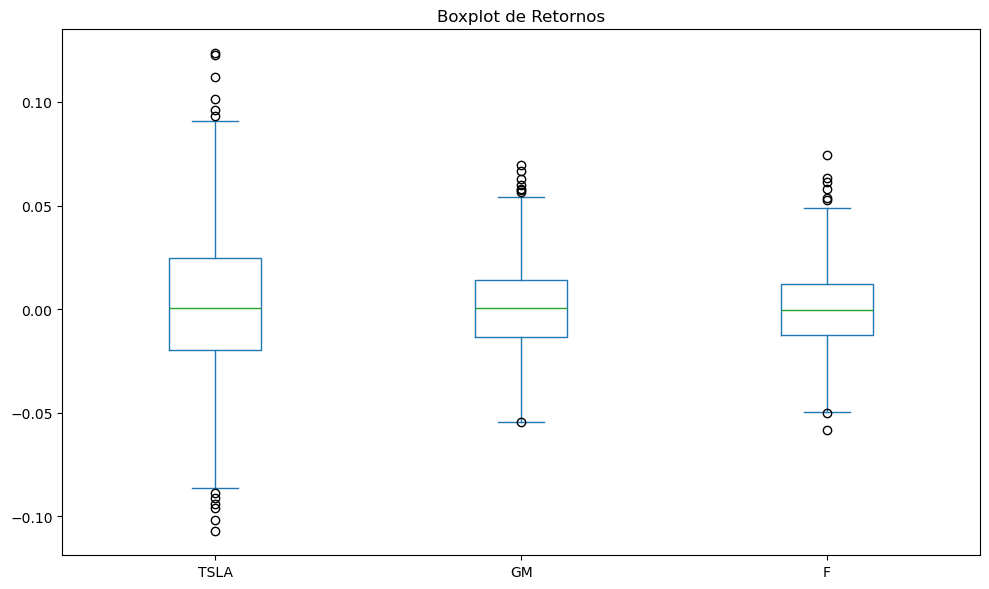

In [11]:
plt.figure(figsize=(12,6))
TSLA['Return'].plot(kind='kde', label='TSLA')
GM['Return'].plot(kind='kde', label='GM')
F['Return'].plot(kind='kde', label='F')
plt.title('KDE Retornos Diarios'); plt.legend(); plt.tight_layout()

box_df = pd.concat([
    TSLA['Return'].rename('TSLA'),
    GM['Return'].rename('GM'),
    F['Return'].rename('F')
], axis=1)

box_df.plot(kind='box', figsize=(10,6), title='Boxplot de Retornos')
plt.tight_layout()

### 4.3 Correlaciones de retornos
Scatter matrix de retornos para ver relaciones lineales.


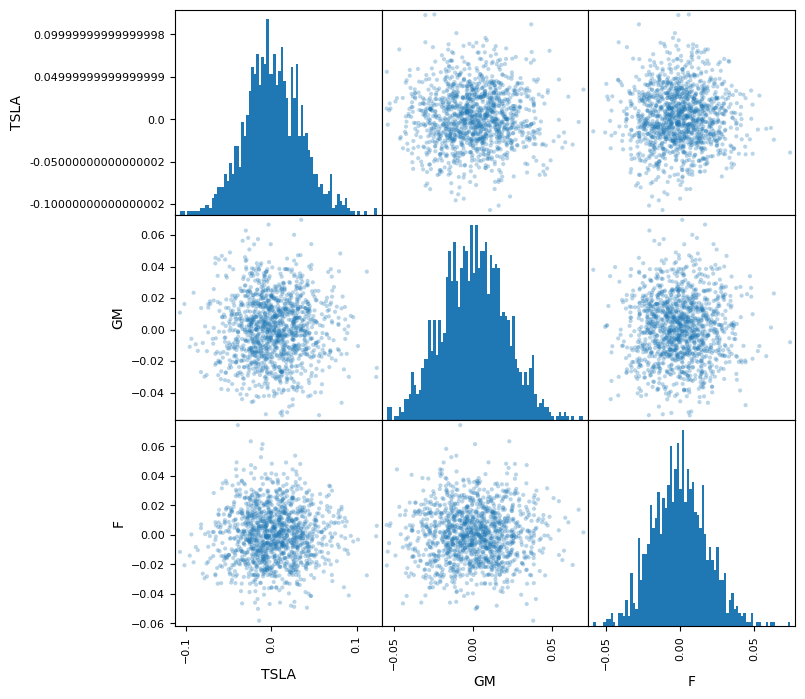

In [12]:
from pandas.plotting import scatter_matrix
_ = scatter_matrix(box_df.dropna(), figsize=(8,8), alpha=0.3, hist_kwds={'bins': 80})

**Ejercicio resuelto (dispersión F vs GM):**
Crea un *scatter plot* de `Return` de F (eje X) vs GM (eje Y).


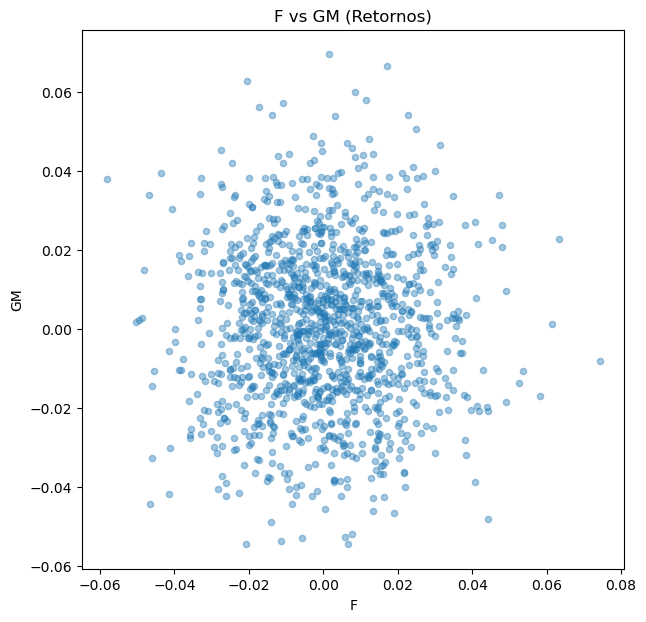

In [13]:
_ = box_df.plot(kind='scatter', x='F', y='GM', figsize=(7,7), alpha=0.4, title='F vs GM (Retornos)')

## 5. Cumulative Daily Returns (CDR)

**Idea:** Evolución de $1 invertido al inicio.
Fórmula con producto acumulado:  
\[ \text{CDR}_t = \prod_{i=1}^{t} (1 + r_i) = \operatorname{cumprod}(1 + r) \]


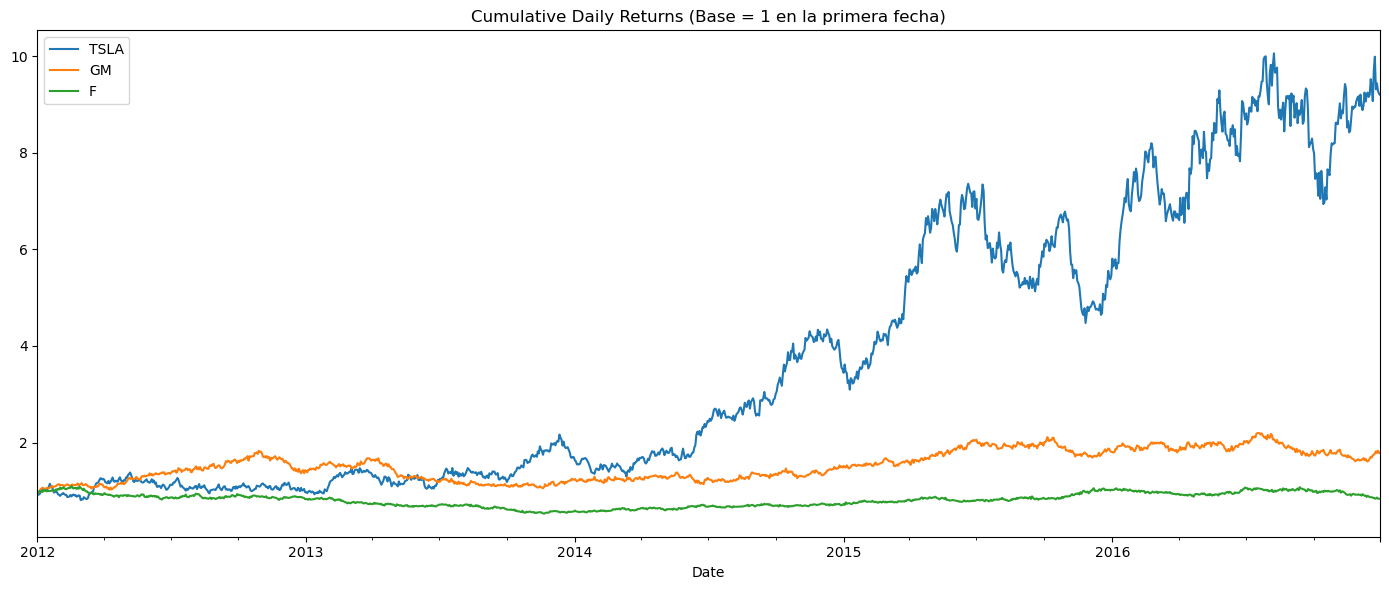

In [14]:
for df in (TSLA, GM, F):
    df['CDR'] = (1 + df['Return']).cumprod()

plt.figure(figsize=(14,6))
TSLA['CDR'].plot(label='TSLA')
GM['CDR'].plot(label='GM')
F['CDR'].plot(label='F')
plt.title('Cumulative Daily Returns (Base = 1 en la primera fecha)')
plt.legend(); plt.tight_layout()

**Ejercicio resuelto:**
¿Cuál tuvo mayor/menor CDR final en el período?


In [15]:
cdr_end = pd.Series({
    'TSLA': TSLA['CDR'].dropna().iloc[-1],
    'GM':   GM['CDR'].dropna().iloc[-1],
    'F':    F['CDR'].dropna().iloc[-1],
}).sort_values(ascending=False)

print("CDR final (mayor→menor):\n", cdr_end.to_frame('CDR_final'))

CDR final (mayor→menor):
       CDR_final
TSLA     9.2005
GM       1.7900
F        0.8367


## 6. Bonus (Opcional): Candlestick de un mes

> Requiere librería `mplfinance`. Si no está instalada, puedes omitir esta sección.
Ejemplo: Ford, enero 2012.


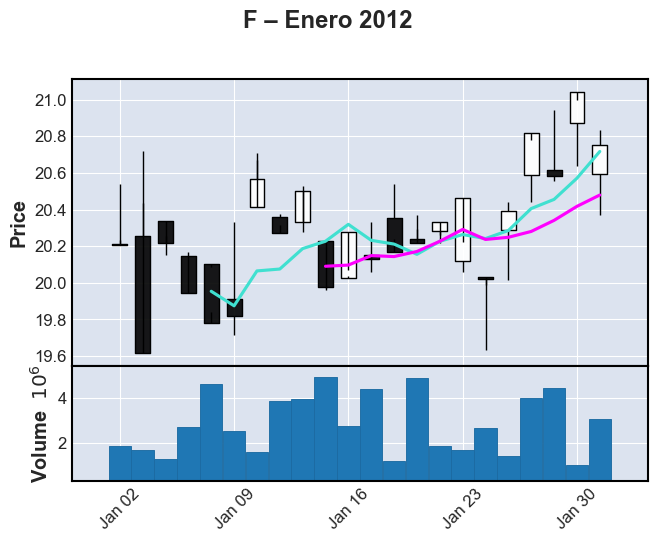

In [16]:
try:
    import mplfinance as mpf
    F_2012_01 = F.loc['2012-01-01':'2012-01-31'][['Open','High','Low','Close','Volume']]
    mpf.plot(F_2012_01, type='candle', mav=(5,10), volume=True, title='F – Enero 2012')
except Exception as e:
    print("Candlestick omitido (instala 'mplfinance' para habilitar). Error:", e)

## 7. Time Series – Conceptos Básicos

- **Trend (tendencia):** Comportamiento medio (↑, →, ↓) en ventanas amplias.
- **Seasonality (estacionalidad):** Patrones repetitivos con período fijo (p. ej., anual).
- **Cyclic (cíclico):** Fluctuaciones sin período fijo (p. ej., ciclos económicos).

### 7.1 Demo de tendencia con filtro HP (Statsmodels) – Opcional


/Users/rodrigojimenez/anaconda3/envs/pyfinance/lib/python3.11/site-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


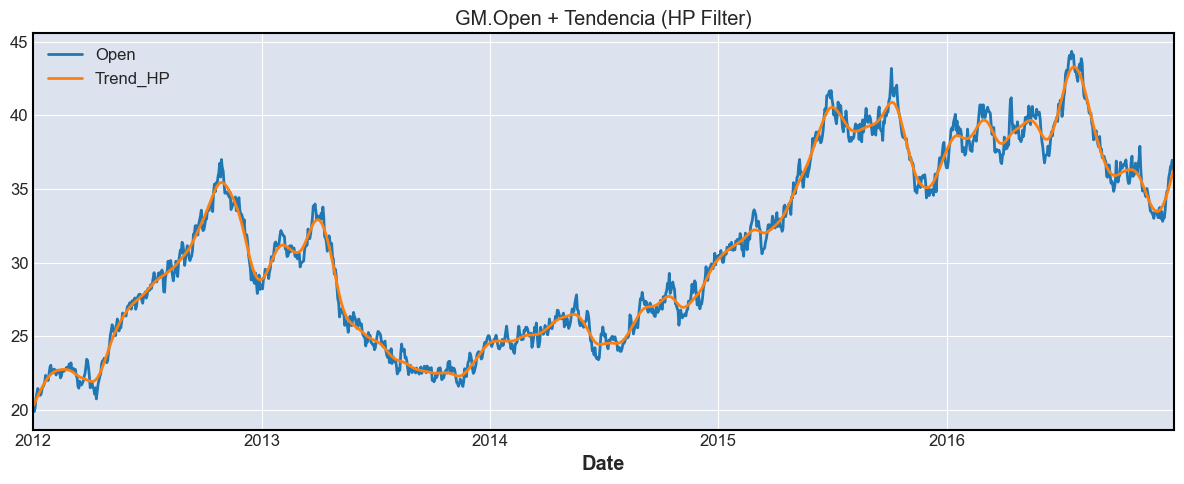

In [17]:
try:
    import statsmodels.api as sm
    # Nota: lambda=1600 es típico para datos trimestrales; ajusta para diarios si lo deseas.
    cycle, trend = sm.tsa.filters.hpfilter(GM['Open'].dropna(), lamb=1600)
    trend.name = 'Trend_HP'
    pd.concat([GM['Open'], trend], axis=1).plot(figsize=(12,5), title='GM.Open + Tendencia (HP Filter)')
    plt.tight_layout()
except Exception as e:
    print("Statsmodels no disponible. Se omite demo HP. Error:", e)

## 8. Resumen Clave (para repaso rápido)

- **Carga de datos:** usa CSV locales si `datareader` no funciona.
- **Gráficos base:** precios, volumen; *TotalTraded* = `Open × Volume` (solo aproximación).
- **Eventos:** picos en volumen pueden señalar noticias relevantes.
- **Medias móviles:** MA(50), MA(200) para suavizar y ver estructura.
- **Retornos diarios:** `pct_change()`; volatilidad ↔ anchura de la distribución.
- **Comparaciones:** KDE, boxplots y *scatter matrix* (precios y retornos).
- **CDR:** producto acumulado de (1 + retorno) = rendimiento de $1 invertido.
- **Time Series:** diferencia entre tendencia, estacionalidad y ciclos; filtros (HP) opcionales.

# 📚 Summary – Stock Market Analysis (Resumen)

- **Price & Volume:** first step is always exploring OHLCV data and spotting outliers/spikes.
- **Moving Averages:** reveal medium/long-term trends and key crossovers (MA50 vs MA200).
- **Returns & Volatility:** quantify daily changes, identify most/least volatile assets.
- **Correlations:** detect co-movement between stocks — crucial for diversification.
- **Visualization:** scatter matrices, histograms, KDE curves help build intuition.

> **Key takeaway:** This notebook is a *quick reference* for exploratory stock analysis:  
> clean data, visualize, calculate returns, compare volatilities, and check correlations.
